# Sistema de Detecção de Equivalência de Disciplinas

# Notebook de verificação da similaridade entre ementas de disciplinas

## Introdução:
O estudante da UFABC passa muito tempo já em sua graduação para terminar as disciplinas do seu BI e do pós-BI e isso afeta principalmente os alunos de cursos mais concorridos como é o de computação, em que as disciplinas podem ter mais de 150% de requisição. Tendo em vista isso, na UFABC temos dois processos já estruturados que é o processo de covalidação e de equivalência, normatizados nas resoluções ConsEPE nº 157/2013 e CG Nº 023/2019 respectivamente. Covalidação é um processo interno da UFABC que é basicamente para a transição de projetos pedagógicos, de forma que o(a) estudante consegue integralizar o curso em um PPC antigo com disciplinas novas e a equivalência é um processo que uma disciplina de fora pode ter alguma similaridade de uma disciplina da ufabc e do curso que você quer se formar. Assim está presente na Resolução CG Nº 023/2019 o seguinte:

>Art. 4º Consistem em requisitos para a dispensa por equivalência, para disciplinas
cursadas no Brasil:

>> I. a carga horária total da disciplina cursada deve ser igual ou maior à carga horária da que se pede equivalência;

>> II. o conteúdo da disciplina cursada deve ser compatível e correspondente a, no mínimo, 75% (setenta e cinco por cento) do conteúdo daquela de que se pede equivalência, considerando-se teoria e prática, quando for o caso. 

>>>Parágrafo único: Excepcionalmente, e mediante justificativa, a coordenação de curso pode autorizar equivalências que cumpram parcialmente estes requisito

Utilizando essa base das normativas e os catálogos de disciplinas da UFABC, objetivamos gerar um sistema de pré-avaliação de disciplinas com alta chance de convalidação, reduzindo o espaço de busca dos técnicos responsaveis pela aprovação de pares de disciplinas com convalidação e garantindo a inclusão de todas as disciplinas na análise. Os benefício desta proposta são a economia de recursos, maior integralização de diferentes PPCs e promove efetivamente a interdisciplinaridade, fundamento da UFAB, uma vez que os cursos poderiam ofertar a mesma disciplina com diferentes enfoques no mesmo quadrimestre, melhorando a qualidade do ensino. Os recursos poupados são tanto na carga de trabalho dos técnicos quanto recursos computacionais (realizada manualmente, ess tarefa tem um complexidade O(n^2)), requerindo análise manual apenas das disciplinas que se encaixam nos critérios das resoluções ConsEPE nº 157/2013 e CG Nº 023/2019 e com alta probabilidade de validação. 

Dessa forma propomos uma análise de similaridade semantica e relacional entre as ementas, os pré-requisitos das disciplinas da UFABC e dos valores de TPEI, para fim de pré-avaliação de equivalências entre as diciplinas da universidade cumprindo com o Art. 4° da resolução CG Nº 023/2019. Assim. em disciplinas que verificarmos que existe uma similaridade equivalente a de pares de disciplinas atualmente validadas (similaridade maior ou igual a 75% e que cumpre a quantidade de creditos da outra disciplina), poderemos gerar listas de pares para aprovação manual em ordem de similaridde. O benefício proporcionado pela maior integração do sistema é difícil de mensurar mas, além de afetar todes es envolvides no processo discente, o alinhamento dessa solução com os sistemas vigentes da universidade amplificam seu impacto e condições em que ele se manifesta.

## Objetivos
1. Fazer uma proposta de equivalência interna de disciplinas a partir da análise de similaridade semântica entre as ementas das disciplinas da UFABC da Graduação e da quantidade de TPEI que elas tem
2. Reduzir o espaço de busca de O(n²) para aproximadamente O(n*log(n)) a partir da aplicação de filtros de TPEI para quantidade de créditos das disciplinas, de forma só comparar as diciplinas que tem a quantidade de créditos iguais

## Métodos
1. Embedding semântico do conteúdo dos Objetivos e Ementas das disciplinas utilizando BERTimbau
2. Cálculo de similaridade cosseno para similaridade entre os textos 
3. Kmeans nos embeddings para determinar agrupamentos de disciplinas ajudando no processo de equivalência
4. Grafo relacional dos Pré-Requisitos entre disciplinas
5. Cálculo de similaridade utiliando distâncias de jaccard
6. Otimização dos hiperparâmetros dos filtros de redução do espaço de busca utilizando modelos de árvores aleatórias 

## 1. Imports e Configuração

In [4]:
# Realiza imports necessários

import csv
import numpy as np
import pandas as pd
import networkx as nx
import unicodedata
import requests
from io import StringIO
from node2vec import Node2Vec
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sentence_transformers import SentenceTransformer, models
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances

c:\Users\angel\Documents\base_dados_disciplinas_ufabc\.venv_disciplinas\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Carregamento de Dados

In [5]:
def carregar_catalogo():
    print("🔄 Baixando catálogo de disciplinas da UFABC...")
    df = pd.read_excel('catalogo_disciplinas_graduacao_2024_2025.xlsx', engine='openpyxl')

    print("✅ Download bem-sucedido!")
    print("📝 Colunas disponíveis:", df.columns.tolist())
    return df


## 3. Preprocessamento e preparação dos Dados

In [8]:
def normalize_text(text):
    '''Normaliza o texto removendo acentuação, pontuação e stopwords. Além disso, aplica stemming, reduzindo a palavra ao seu radical.'''
    if pd.isna(text):
        return []

    norm = unicodedata.normalize('NFKD', str(text))
    norm = norm.encode('ASCII', 'ignore').decode('utf-8')
    norm = re.sub(r'[^\w\s]', '', str(text).lower())
    norm = norm.lower().strip()
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in text.split() if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)


def extract_tpei(tpei_str):
    '''Extrai os valores de TPEI (Teoria, Prática, Extensão e Individual) de uma string no formato "T-P-E-I" e retorna um dicionário com os valores.
        Se a string for inválida, retorna um dicionário vazio.'''
    if pd.isna(tpei_str) or tpei_str == "TPEI":
        return []
    
    values = tpei_str.split('-')
    return {
        'teoria': int(values[0]),
        'pratica': int(values[1]),
        'extensao': int(values[2]),
        'individual': int(values[3]),
        'total_creditos': int(values[0]) + int(values[1])  # T+P only
    }

def extract_prereq(recomendacao):
    '''Extrai os pré-requisitos de uma string no formato "Disciplina1; Disciplina2; ..." e retorna uma lista com os códigos das disciplinas.
        Se a string for inválida, retorna uma lista vazia.'''
    if pd.isna(recomendacao) or recomendacao.strip() == '' or recomendacao == 'Não há':
        return []

    prereqs = []
    for part in recomendacao.split(';'):
        part = part.strip()
        if part:
            prereqs.append(part)
    return prereqs

def create_allfeats(df):
    '''Cria todas as features necessárias para o modelo de recomendação. Retorna um DataFrame com as features criadas.'''
    df = df.copy()

    # TPEI
    tpei_feats = df['TPEI'].apply(extract_tpei)
    df['teoria'] = tpei_feats.apply(lambda x: x['teoria'])
    df['pratica'] = tpei_feats.apply(lambda x: x['pratica'])
    df['extensao'] = tpei_feats.apply(lambda x: x['extensao'])
    df['individual'] = tpei_feats.apply(lambda x: x['individual'])
    df['total_creditos'] = tpei_feats.apply(lambda x: x['total_creditos'])

    # Ementa
    df['ementa_norm'] = df['EMENTA'].apply(normalize_text)
    df['objetivos_norm'] = df['OBJETIVOS'].apply(normalize_text)

    # Pré-requisitos
    df['prerequisites'] = df['RECOMENDAÇÃO'].apply(extract_prereq)
    df['num_prerequisites'] = df['prerequisites'].apply(len)
    df['codigo'] = df['SIGLA'].apply(normalize_text)

    return df

In [9]:
#### inicializar os dados
#carregar o catálogo de disciplinas
df = carregar_catalogo()
# realizar o pré-processamento dos dados criando as features
df = create_allfeats(df)
# df

🔄 Baixando catálogo de disciplinas da UFABC...
✅ Download bem-sucedido!
📝 Colunas disponíveis: ['SIGLA', 'DISCIPLINA', 'TPEI', 'RECOMENDAÇÃO', 'OBJETIVOS', 'METODOLOGIA EXTENSIONISTA', 'EMENTA', 'BIBLIOGRAFIA BÁSICA', 'BIBLIOGRAFIA COMPLEMENTAR']


## 4. Filtro TPEI

In [ ]:
def aplicar_filtro_tpei(df_pares, df_disciplinas):
    print("Aplicando filtro TPEI...")
    
    # Criar dicionário para mapeamento rápido de sigla -> créditos
    creditos_dict = {row['SIGLA']: row['total_creditos'] 
                    for _, row in df_disciplinas.iterrows() 
                    if pd.notna(row['SIGLA'])}
    
    # DataFrame para armazenar pares filtrados
    pares_filtrados = []
    
    # Dicionário para armazenar diferenças de créditos
    tpei_dif = {}
    
    # Registrar pares excluídos para log
    pares_excluidos = []
    
    # Aplicar filtro a cada par
    for _, row in df_pares.iterrows():
        sigla_a = row['SIGLA_A']  # current
        sigla_b = row['SIGLA_B']  # comp
        
        # Verificar se ambas as siglas existem no dicionário
        if sigla_a not in creditos_dict or sigla_b not in creditos_dict:
            pares_excluidos.append((sigla_a, sigla_b, "Sigla não encontrada"))
            continue
        
        creditos_a = creditos_dict[sigla_a]
        creditos_b = creditos_dict[sigla_b]
        
        # Verificar a regra de filtro
        if creditos_a > creditos_b:
            # Remover par se créditos de A > créditos de B
            pares_excluidos.append((sigla_a, sigla_b, f"Créditos A({creditos_a}) > B({creditos_b})"))
        else:
            # Manter o par e calcular a diferença
            pares_filtrados.append(row)
            tpei_dif[(sigla_a, sigla_b)] = creditos_b - creditos_a
    
    # Criar DataFrame com pares filtrados
    df_filtrado = pd.DataFrame(pares_filtrados)
    
    print(f"✅ Filtro TPEI aplicado: {len(df_filtrado)} pares mantidos, {len(pares_excluidos)} excluídos")
    
    return df_filtrado, tpei_dif

## 5. Filtro de Pré-requisitos

In [ ]:
#  Constrói grafo com arestas de pré-requisito com base na coluna RECOMENDACAO
def construir_grafo(df: pd.DataFrame) -> nx.DiGraph:
    print("📌 Construindo grafo de pré-requisitos...")
    G = nx.DiGraph()
    total_arestas = 0

    # Cria um dicionário de nome normalizado → sigla
    mapping = {
        normalize_text(row['DISCIPLINA']): row['SIGLA']
        for _, row in df.iterrows()
        if pd.notna(row['SIGLA'])
    }

    # Adiciona todos os nós com metadados
    for _, row in df.iterrows():
        sigla = row['SIGLA']
        nome = row['DISCIPLINA']
        if pd.isna(sigla): 
            continue
        G.add_node(sigla, nome=nome)

    # Adiciona as arestas baseadas nas recomendações
    for _, row in df.iterrows():
        curso = row['SIGLA']
        if pd.isna(curso):
            continue

        recs = row.get('RECOMENDACAO', '')
        if pd.isna(recs) or not isinstance(recs, str):
            continue

        for rec in recs.split(';'):
            rec = rec.strip()
            if not rec:
                continue
            rec_norm = normalize_text(rec)
            if rec_norm in mapping:
                prereq = mapping[rec_norm]
                if not G.has_edge(prereq, curso):
                    G.add_edge(prereq, curso, tipo='pre_requisito')
                    total_arestas += 1

    print(f"✅ Grafo criado com {G.number_of_nodes()} nós e {total_arestas} arestas.")
    return G

### Processamento do Grafo: Rede Direcionada e Embeddings Estruturais

In [ ]:
#  Remove ciclos do grafo para que seja um DAG (necessário para cálculo de profundidade)
def remover_ciclos(G: nx.DiGraph) -> nx.DiGraph:
    print("🔁 Removendo ciclos (modo eficiente)...")
    G_copy = G.copy()
    removidos = 0
    try:
        while True:
            ciclo = nx.find_cycle(G_copy, orientation='original')
            if ciclo:
                # Remove a primeira aresta do ciclo
                u, v, _ = ciclo[0]
                G_copy.remove_edge(u, v)
                removidos += 1
    except nx.NetworkXNoCycle:
        pass  # Não há mais ciclos

    print(f"✅ Ciclos removidos: {removidos}")
    return G_copy

# Gera embeddings estruturais com Node2Vec
def gerar_embeddings_node2vec(G: nx.DiGraph, dimensions=64, walk_length=10, num_walks=50, workers=1):
    print("🔄 Gerando embeddings estruturais (Node2Vec)...")
    node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    model = node2vec.fit(window=5, min_count=1, batch_words=4)
    embeddings = {node: model.wv[node] for node in G.nodes()}
    print("✅ Embeddings gerados!")
    return embeddings

# Calcula profundidade de cada nó no grafo (camada curricular)
def calcular_profundidade(G: nx.DiGraph):
    print("📏 Calculando profundidade no grafo (DAG)...")
    profundidades = {}
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        if not preds:
            profundidades[node] = 0
        else:
            profundidades[node] = max(profundidades[p] for p in preds) + 1
    print("✅ Profundidade calculada!")
    return profundidades

# Salva os embeddings em CSV
def salvar_embeddings_csv(embeddings, caminho="embeddings_node2vec.csv"):
    df = pd.DataFrame.from_dict(embeddings, orient='index')
    df.index.name = 'DISCIPLINA'
    df.to_csv(caminho)
    print(f"💾 Embeddings salvos em: {caminho}")

# Fluxo principal
if __name__ == "__main__":
    # Etapa 1 - Carregar catálogo
    df = carregar_catalogo()

    # Etapa 2 - Construir grafo
    grafo = construir_grafo(df)
    nx.write_graphml(grafo, "grafo_pre_requisitos.graphml")
    print("📁 Arquivo salvo: grafo_pre_requisitos.graphml")

    # Etapa 3 - Gerar embeddings estruturais
    embeddings = gerar_embeddings_node2vec(grafo)
    salvar_embeddings_csv(embeddings)

    # Etapa 4 - Remover ciclos e calcular profundidade
    grafo_sem_ciclos = remover_ciclos(grafo)
    profundidades = calcular_profundidade(grafo_sem_ciclos)

    # Etapa 5 - Salvar profundidades em TXT
    with open("profundidade_nos.txt", "w") as f:
        for node, prof in profundidades.items():
            f.write(f"{node}: {prof}\n")
    print("📁 Profundidades salvas em: profundidade_nos.txt")

### Com o grafo pronto e os dados carregados, aplicaremos o Índice de Jaccard e outras medidas de similaridade para analisar as conexões entre as disciplinas.
-  O índice de Jaccard calcula a similaridade entre dois conjuntos com a razão do tamanho da intersecção pelo tamanho da união e retorna um valor de 0 a 1. Como estamos usando um grafo direcionado em que os vértices são as disciplinas e as arestas a similaridade entre elas, o conjunto para a comparação passa a ser as recomendações de duas disciplinas sucessoras ou predecessoras.
- A similaridade de profundidade compara a proximidade de dois nós em termos de níveis do grafo, retornando valores de 0 a 1 em que 1 ocorre quando os nós estão no mesmo nível. Nesse contexto, a métrica retornará a comparação de



In [ ]:
# Jaccard entre dois conjuntos
def jaccard_similarity(set1, set2):
    if not set1 or not set2:
        return 0.0
    return len(set1 & set2) / len(set1 | set2)

# Aplica Jaccard entre predecessores ou sucessores
def similaridade_jaccard(G, a, b, tipo='predecessor'):
    try:
        if tipo == 'predecessor':
            set_a = set(G.predecessors(a))
            set_b = set(G.predecessors(b))
        else:
            set_a = set(G.successors(a))
            set_b = set(G.successors(b))
        return jaccard_similarity(set_a, set_b)
    except nx.NetworkXError:
        return 0.0
    
# Similaridade de profundidade
def similaridade_profundidade(prof, a, b):
    if a not in prof or b not in prof:
        return 0.0
    max_p = max(prof.values())
    if max_p == 0:
        return 1.0
    return 1.0 - abs(prof[a] - prof[b]) / max_p

# Similaridade por Node2Vec (cosseno)
def similaridade_node2vec(embeddings, a, b):
    if a not in embeddings.index or b not in embeddings.index:
        return 0.0
    vec_a = embeddings.loc[a].values.reshape(1, -1)
    vec_b = embeddings.loc[b].values.reshape(1, -1)
    return cosine_similarity(vec_a, vec_b)[0][0]



### Combinação das Similaridades em um Score Final

In [ ]:
# Combina múltiplas similaridades em score final
def similaridade_combinada(G, embeddings, profundidades, a, b, pesos=None):
    if pesos is None:
        pesos = {
            'jaccard_pred': 1.0,
            'jaccard_succ': 1.0,
            'profundidade': 1.0,
            'node2vec': 1.0,
        }

    sim_jaccard_pred = similaridade_jaccard(G, a, b, tipo='predecessor')
    sim_jaccard_succ = similaridade_jaccard(G, a, b, tipo='successor')
    sim_profundidade = similaridade_profundidade(profundidades, a, b)
    sim_node2vec = similaridade_node2vec(embeddings, a, b)

    total_peso = sum(pesos.values())
    score = (
        pesos['jaccard_pred'] * sim_jaccard_pred +
        pesos['jaccard_succ'] * sim_jaccard_succ +
        pesos['profundidade'] * sim_profundidade +
        pesos['node2vec'] * sim_node2vec
    ) / total_peso

    return {
        "score_combinado": score,
        "jaccard_pred": sim_jaccard_pred,
        "jaccard_succ": sim_jaccard_succ,
        "profundidade": sim_profundidade,
        "node2vec": sim_node2vec
    }

###  Geração do arquivo de similaridades filtradas (.tsv)

In [ ]:
# Escrita incremental com filtro de profundidade e TPEI
if __name__ == "__main__":
    grafo = carregar_grafo()
    embeddings = carregar_embeddings()
    profundidades = carregar_profundidades()

    caminho_saida = "similaridades_disciplinas_filtrado.tsv"
    with open(caminho_saida, mode="w", newline='', encoding='utf-8') as f_out:
        writer = csv.writer(f_out, delimiter="\t")
        # Cabeçalho
        writer.writerow([
            "disciplina_a", "disciplina_b", "score_combinado",
            "jaccard_pred", "jaccard_succ", "profundidade", "node2vec"
        ])

        # Laço otimizado com filtros
        for a in grafo.nodes():
            for b in grafo.nodes():
                if a == b:
                    continue

                # Filtro por profundidade (ex: 2 níveis no máximo)
                if abs(profundidades.get(a, 0) - profundidades.get(b, 0)) > 2:
                    continue

                sim = similaridade_combinada(grafo, embeddings, profundidades, a, b)
                writer.writerow([
                    a, b, sim["score_combinado"],
                    sim["jaccard_pred"], sim["jaccard_succ"],
                    sim["profundidade"], sim["node2vec"]
                ])

    print(f"✅ Arquivo '{caminho_saida}' gerado com sucesso.")

    # AVISO: O ARQUIVO .TSV CONTENDO O RESULTADO DAS ANÁLISES PODE DEMORAR PARA SER GERADO DEPENDENDO DA MÁQUINA UTILIZADA PARA A EXECUÇÃO!!

## 6. Cálculo de Score TPEI + Pré-requisitos

In [35]:
# Prepara matriz de caracteristicas
def prepare_combined_features(discipline_pairs, tpei_diff, prereq_similarities):
    features = []
    
    pares_filtrados = []
    
    pares_excluidos = []
    
    for pair in discipline_pairs:
        prereq_sim = prereq_similarities.get(pairs, 0.0)
        features.append([tpei_diff, prereq_sim])
    return np.array(features)


# Treina CatBoost usando labeled_data
# Código da Larissa



# Otimiza limiar
# from sklearn.metrics import precision_recall_curve
y_pred_proba = model_catboost.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Calcula score de cada par
all_features = prepare_combined_features(candidate_pairs, tpei_diff, prereq_similarities)
combined_scores = model_catboost.predict_proba(all_features)[:, 1]

# Aplica filtro em cada par
filtered_pairs = [
    pair for pair, score in zip(candidate_pairs, combined_scores)
    if score >= optimal_threshold
]

NameError: name 'model_catboost' is not defined

# Sentence BERT

O BERT é um pacote que cria embeddings de palavras a partir de uma rede já treinada. Os embeddings carregam no seus valores o conteudo semantico de cada palavra a partir de uma representação vetorial de cada palavra

O Sentence BERT ou SBERT utiliza esses embedings de cada palavra e calula o significado médio, por exemplo, de cada frase, de forma que temos uma noção do que cada sentença significa.

existem 1353 disciplinas e no primeiro momento calculamos a similaridade cosseno entre todos os pares. Assim a cossine_sim_bert terá a dimensão 1353x1353

In [ ]:
def sao_variantes_simples(nome1, nome2):
    base1 = re.sub(r'[\s\-]*(laboratório|[a-zA-Z]{1,3}|[ivxIVX0-9]{1,4})\s*$', '', nome1.strip(), flags=re.IGNORECASE)
    base2 = re.sub(r'[\s\-]*(laboratório|[a-zA-Z]{1,3}|[ivxIVX0-9]{1,4})\s*$', '', nome2.strip(), flags=re.IGNORECASE)
    return base1.lower() == base2.lower()

def similariry_between_DISCIPLINA(dataframe, cosine_sim, similarity_threshold = 0.75):
    '''Encontrar pares com similaridade ≥ 75% e faz o print dos nomes das disciplinas.
        dataframe: DataFrame com os dados das disciplinas
        cosine_sim: matriz de similaridade entre as disciplinas
        similarity_threshold: limiar de similaridade (default: 0.75)'''

    similar_pairs = []
    n = len(dataframe)
    for i in range(n):
        for j in range(i+1, n):  # Evitar duplicatas (i, j) e (j, i)
            nome_i = dataframe.iloc[i]['DISCIPLINA']
            nome_j = dataframe.iloc[j]['DISCIPLINA']
            if sao_variantes_simples(nome_i, nome_j):
                continue  # pula se são versões quase idênticas da mesma disciplina
            if cosine_sim[i, j] >= similarity_threshold:
                similar_pairs.append((nome_i, nome_j, cosine_sim[i, j]))

    # Exibir resultados
    for pair in similar_pairs:
        print(f"Disciplinas similares: {pair[0]} e {pair[1]} (Similaridade: {pair[2]:.2f})")
    
    return similar_pairs


# Criar modelo SBERT para o português para a coluna, usando o modelo BERT pré-treinado para português
model_name = "neuralmind/bert-base-portuguese-cased"
word_embedding_model = models.Transformer(model_name)

# Definir o modelo de pooling para agregar os embeddings. O pooling combina os embeddings de palavras em um único vetor
# Usando o modo de pooling médio, que calcula a média dos embeddings de palavras

pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True)


# Estancia o modelo SBERT com o modelo de embedding e o modelo de pooling
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# Calcula embeddings para as EMENTAS
embeddings = model.encode(
    df['ementa_norm'].tolist(),
    normalize_embeddings=True  # garante que todos os vetores têm norma 1
)

#calcular a similaridade entre os embeddings usando a similaridade do cosseno
cosine_sim_sbert = cosine_similarity(embeddings, embeddings)

# Fazer o print da similaridade entre as disciplinas com o threshold de 0.75
sim_pair = similariry_between_DISCIPLINA(df, cosine_sim_sbert)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Disciplinas similares: ESZR007-21 e ESHR027-21 (Similaridade: 0.76)
Disciplinas similares: ESZR007-21 e ESZR003-21 (Similaridade: 0.83)
Disciplinas similares: ESZR007-21 e MCZB001-13 (Similaridade: 0.80)
Disciplinas similares: ESZR007-21 e ESZR023-21 (Similaridade: 0.83)
Disciplinas similares: ESZR007-21 e ESHR018-21 (Similaridade: 0.76)
Disciplinas similares: ESZR007-21 e ESZR024-21 (Similaridade: 0.86)
Disciplinas similares: ESZR007-21 e ESZR001-13 (Similaridade: 0.76)
Disciplinas similares: ESZR007-21 e ESZR025-21 (Similaridade: 0.88)
Disciplinas similares: ESZR007-21 e NHZ2093-16 (Similaridade: 0.80)
Disciplinas similares: ESZR007-21 e ESHT025-17 (Similaridade: 0.78)
Disciplinas similares: ESZR007-21 e ESZR026-21 (Similaridade: 0.85)
Disciplinas similares: ESZR007-21 e ESZR027-21 (Similaridade: 0.83)
Disciplinas similares: ESZR007-21 e ESZR028-21 (Similaridade: 0.81)
Disciplinas similares: ESZR007-21 e ESHC012-21 (Similaridade: 0.75)
Disciplinas similares: ESZR007-21 e ESHP021-21 (

In [ ]:
sim_pair = similariry_between_DISCIPLINA(df, cosine_sim_sbert, similarity_threshold = 0.8)

## K-means 

vamos rodar o K-means para determinar se existe algum cluster de disciplinas que poderiamos agrupar. É uma outra forma de entender similaridade agora visto com agrupamento de elemntos semelhantes para pensar as equivalencias internas. 

Começamos por determinar os K otimo para esse método utilizando o metodo do cotovelo e o metodo da estatitica de gap

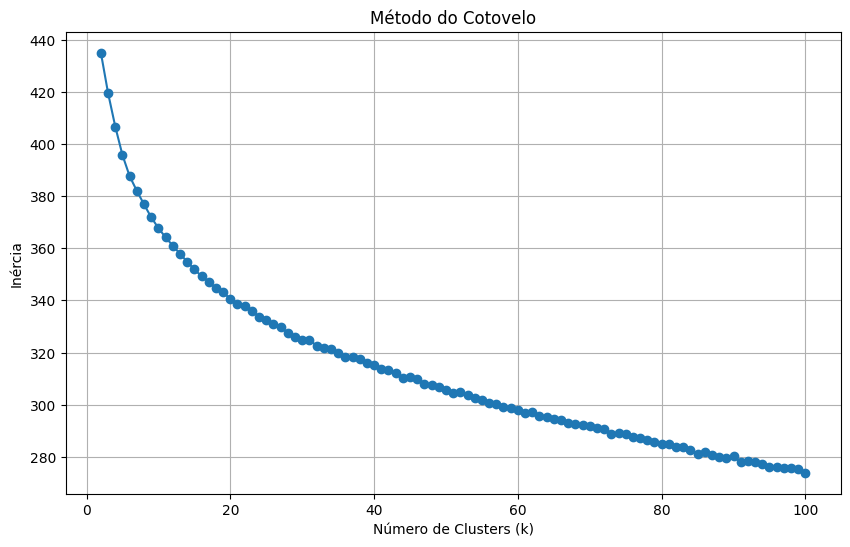

In [11]:
# fazer um kmeans para encontrar o número ideal de clusters utilizando o método do cotovelo
# O método do cotovelo é uma técnica usada para determinar o número ideal de clusters em um conjunto de dados

def find_optimal_k(data, max_k=40):
    # Lista para armazenar os valores de inércia
    inertia = []
    
    # Testar diferentes valores de k
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    # Plotar o gráfico do método do cotovelo
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), inertia, marker='o')
    plt.title('Método do Cotovelo')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inércia')
    plt.grid(True)
    plt.show()

# Chamar a função para encontrar o número ideal de clusters
find_optimal_k(embeddings, max_k=100)

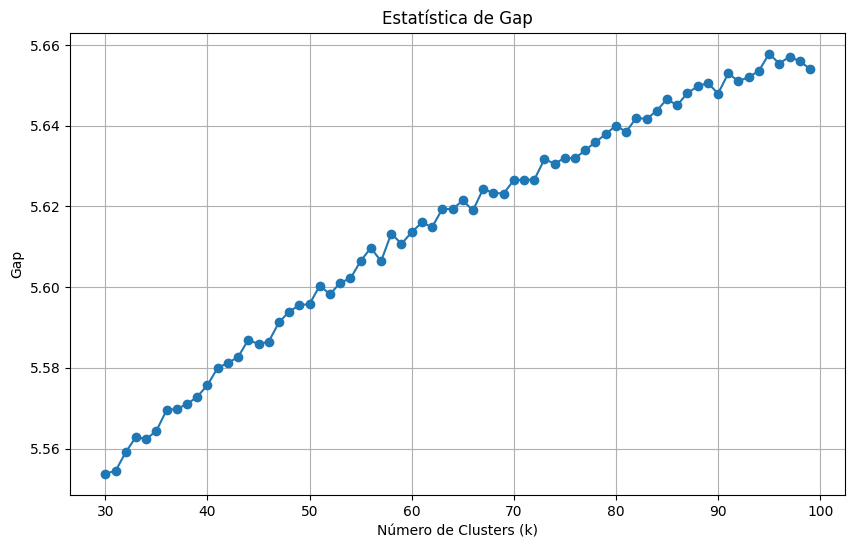

In [12]:
# fazer um kmeneans para encontrar o número ideal de clusters utilizando o método da estatistica de Gap
# O método da estatística de Gap é uma técnica usada para determinar o número ideal de clusters em um conjunto de dados

def gap_statistic(data, n_clusters_range, n_repeats=10):
    # Lista para armazenar os valores de Gap
    gaps = []
    
    # Calcular o Gap para cada valor de k
    for k in n_clusters_range:
        # Ajustar o modelo KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        
        # Calcular a inércia do modelo ajustado
        inertia = kmeans.inertia_
        
        # Gerar dados aleatórios para comparação
        random_data = np.random.random_sample(size=data.shape)
        
        # Ajustar o modelo KMeans aos dados aleatórios
        kmeans_random = KMeans(n_clusters=k, random_state=42)
        kmeans_random.fit(random_data)
        
        # Calcular a inércia do modelo ajustado aos dados aleatórios
        inertia_random = kmeans_random.inertia_
        
        # Calcular o Gap e adicionar à lista
        gap = np.log(inertia_random) - np.log(inertia)
        gaps.append(gap)
    
    return gaps

# Definir o intervalo de k para testar
n_clusters_range = range(30, 100)
# Calcular a estatística de Gap
gaps = gap_statistic(embeddings, n_clusters_range)
# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, gaps, marker='o')
plt.title('Estatística de Gap')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap')
plt.grid(True)
plt.show()

Considerando que nos dois métodos que utilizamos de determinação do numero otimo para o k deram inconclusivos vamos partir de uma hipotese a priori que toma em conta que na UFABC existem 31 cursos, sendo 4 BI/LI e 27 pós-BI/LI. Alem disso para cada curso temos disciplinas obrigatórias e limitadas. Assim vamos considerar a k=62 tendo em conta esses pontos. 

In [13]:
# Fazendo o modelo de Kmeans para o numero de clusters determinado
kmeans_final = KMeans(n_clusters=62, random_state=42, n_init=10)

# Ajustar o modelo KMeans aos dados de embeddings
# Encontrar disciplina que está no centroide de cada cluster
kmeans_final.fit(embeddings)
# Obter os rótulos dos clusters
labels = kmeans_final.labels_
# Obter os centróides dos clusters
centroids = kmeans_final.cluster_centers_
# Calcular a distância euclidiana entre os embeddings e os centróides
distances = euclidean_distances(embeddings, centroids)
# Obter o índice do centróide mais próximo para cada disciplina
closest_centroid_indices = np.argmin(distances, axis=0)
# printar os rótulos dos clusters e os centróides
for i in range(len(centroids)):
    print(f"Cluster {i}:")
    # Obter os índices das disciplinas que pertencem ao cluster i
    cluster_indices = np.where(labels == i)[0]
    # Obter os nomes das disciplinas que pertencem ao cluster i
    cluster_disciplines = df.iloc[cluster_indices]['DISCIPLINA'].tolist()
    # Obter o nome da disciplina mais próxima do centróide
    closest_discipline = df.iloc[closest_centroid_indices[i]]['DISCIPLINA']
    print(f"Disciplinas: {cluster_disciplines}")
    print(f"Disciplina mais próxima do centróide: {closest_discipline}")
    print()

Cluster 0:
Disciplinas: ['Engenharia de segurança do trabalho', 'Gerência de Ativos', 'Programação Segura', 'Qualidade em Sistemas', 'Robôs Móveis Autônomos', 'Segurança de Dados', 'Segurança de Redes', 'Segurança em Laboratórios de Química', 'Segurança em Redes']
Disciplina mais próxima do centróide: Segurança de Dados

Cluster 1:
Disciplinas: ['Bases Epistemológicas da Ciência Moderna', 'Discussões Atuais em Filosofia da Ciência', 'Epistemologia Naturalizada', 'Filosofia da Ciência', 'História das Ideias Biológicas', 'História e Filosofia da Biologia', 'História e Filosofia da Economia e das Ciências Sociais', 'História e Filosofia da Física', 'História e Filosofia das Ciências e o Ensino de Ciências', 'Metodologias de Pesquisa em Educação', 'Modelagem Econômica no Século XXI', 'Teoria do Conhecimento Científico']
Disciplina mais próxima do centróide: Discussões Atuais em Filosofia da Ciência

Cluster 2:
Disciplinas: ['Álgebra Comutativa', 'Análise no Rn I', 'Análise no Rn II', 'Anál

## 8. Cálculo de Score Final

In [ ]:
# Prepara caracteristicas
def prepare_final_features(pairs, tpei_dif, prereq_sim, ementa_sim):
    features = []
    for pair in pairs:
        prereq = prereq_sim.get(pair, 0.0)
        ementa = ementa_sim(pair, 0.0)
        features.append([tpei_dif, prereq, ementa])
    return np.array(features)

# Treino SVM com Kernel RBF
# Codigo da Larissa

# Calcula limiar ótimo
y_prob = svm_model.predict_proba(X_scaled)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_final, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
final_threshold = thresholds[np.argmax(f1_scores)]

all_final_features = prepare_final_features(
    filtered_pairs, tpei_dif, prereq_sim, ementa_sim
)
all_scaled = scaler.transform(all_final_features)
final_scores = svm_model.predict_proba(all_scaled)[:, 1]

#Lista final de pares
equivalent_pairs = [
    (pair, score) for pair, score in zip(filtered_pairs, final_scores)
    if score >= final_threshold
]

## 9. Explicação dos Resultados

In [ ]:
# import shap
explainer = shap.KernelExplainer(
    svm_model.predict_proba,
    X_scaled,
    link="logit"
)

shap_values = explainer.shap_values(all_scaled)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

feature_names = ['Diferença de créditos', 'Similaridade de pré-requisito', 'Similaridade de ementa']
importance = np.abs(shap_values).mean(0)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

def explain_prediction(pair_index, features, shap_values):
    feature_values = features[pair_index]
    shap_value = shap_values[pair_index]
    
    explanation = []
    for i, (name, value, impact) in enumerate(zip(feature_names, feature_values, shap_value)):
        direction = "positive" if impact > 0 else "negative"
        explanation.append(f"{name}: {value:.3f} ({direction} impact: {abs(impact):.3f})")
    
    return "\n".join(explanation)

# Generate explanations for all equivalent pairs
explanations = []
for i, (pair, score) in enumerate(equivalent_pairs):
    explanation = f"Pair: {pair[0]} - {pair[1]}\n"
    explanation += f"Equivalence Score: {score:.3f}\n"
    explanation += "Feature Contributions:\n"
    explanation += explain_prediction(i, all_final_features, shap_values)
    explanations.append(explanation)
# Initialize SHAP explainer for SVM model
# Calculate SHAP values for each prediction
# Generate feature importance rankings
# Create individual prediction explanations
# Prepare text explanations for results

## 10. Visualizações dos Resultados

### 10.1 Matriz de visualização

In [ ]:
# Criar grafo
G = nx.Graph()

df = pd.DataFrame

# Adicionar nós (disciplinas)
for sigla in df['DISCIPLINA'].unique():
    G.add_node(sigla)

# Modificar a criação de arestas
for pair in similar_pairs:
    disciplina_a, disciplina_b, similarity = pair
    if similarity >= 0.8:  # Ajuste o threshold aqui
        G.add_edge(disciplina_a, disciplina_b, weight=similarity)

        # Calcular posições dos nós
        pos = nx.kamada_kawai_layout(G, weight='weight')  # Usa o peso (similaridade) para organizar

        # Criar traços para arestas
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])  # None para separar linhas
            edge_y.extend([y0, y1, None])
        
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line= dict(width=1, color='#888'),  # Espessura e cor das arestas
            hoverinfo='none',
            mode='lines')

# Criar traços para nós
node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)  # Texto ao passar o mouse

node_trace = go.Scatter(
  x=node_x, y=node_y,
  mode='markers+text',
  text=node_text,
  textposition="top center",
  hoverinfo='text',
  marker=dict(
      showscale=True,
      colorscale='YlGnBu',
      size=15,
      color=[],  # Pode ser usado para codificar cores por comunidade
      line=dict(width=2, color='black'))
)

# Criar figura
fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
)

# Adicionar interatividade (exibir sigla ao passar o mouse)
fig.update_traces(textposition='top center', hoverinfo='text')

from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
# Atribuir cores diferentes a cada comunidade

fig.show()

# Create DiGraph visualization showing prerequisite relationships
# Color nodes based on equivalence status
# Highlight connected discipline pairs
# Add node labels and edge weights
# Save graph visualization

### 10.2 Visualização por mapa de calor

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carrega o TSV
df = pd.read_csv("similaridades_disciplinas_filtrado.tsv", sep="\t")

# Seleciona 50 pares representativos
amostras = pd.concat([
    df.nlargest(10, 'score_combinado'),
    df.nsmallest(10, 'score_combinado'),
    df.nlargest(10, 'node2vec'),
    df[df['jaccard_pred'] > 0].sample(10, random_state=42),
    df.sample(10, random_state=7)
]).drop_duplicates().reset_index(drop=True)

# Indexação legível
amostras.index = amostras["disciplina_a"] + " vs " + amostras["disciplina_b"]

# Métricas para o heatmap
metricas = ["score_combinado", "jaccard_pred", "jaccard_succ", "profundidade", "node2vec"]

# Cria o heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(amostras[metricas], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Mapa de Calor: Similaridade Entre Disciplinas (50 pares)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'similaridades_disciplinas_filtrado.tsv'

O gráfico abaixo apresenta um heatmap com 50 pares de disciplinas selecionados de forma representativa para demonstrar padrões nas métricas de similaridade utilizadas:

score_combinado: medida geral de similaridade calculada com base em múltiplos critérios.

jaccard_pred e jaccard_succ: medem sobreposição de pré-requisitos e sucessores, respectivamente.

profundidade: indica o quão próximas as disciplinas estão em termos de nível curricular.

node2vec: representa a semelhança estrutural entre disciplinas no grafo de currículo.

Os pares foram escolhidos para cobrir casos com alta e baixa similaridade, fortes conexões por embeddings, e exemplos aleatórios, oferecendo interpretável das relações entre disciplinas.

![alt text](mapac-1.png)

### 10.3 Matrizes de Confusão

In [ ]:
# Calculate confusion matrix for model performance
# Create heatmap visualization of confusion matrix
# Add precision, recall, and F1 scores
# Generate performance metrics report

## 11. Exportação de Resultados

In [ ]:
# Save filtered results to TSV file
# Export model performance metrics
# Save visualizations in specified formats
# Generate final summary report

## Limitações:

Primeiramente esse não é um curso de educação e portanto as similarides encontradas aqui não refletem necessariamente a similaridade do que é passado em sala de aula. Aqui o foco é sujerir alterações entre as disciplinas da universidade buscando maior interdisiciplinariedade. 

## Conclusões
Podemos pensar em disciplinas comuns a diferentes cursos como por exemplo as disciplinas similares encontradas: 

- Disciplinas similares: Introdução à Inferência Estatística e Introdução à Probabilidade e à Estatística (Similaridade: 0.84)
- Disciplinas similares: Introdução à Inferência Estatística e Métodos Empíricos para Avaliação de Políticas Públicas (Similaridade: 0.81)
- Disciplinas similares: Introdução à Inferência Estatística e Métodos Quantitativos em Políticas Públicas (Similaridade: 0.92)
- Disciplinas similares: Introdução à Inferência Estatística e Técnicas de Tomadas de Decisão Aplicáveis em Modelos de Dependência (Similaridade: 0.82)
- Disciplinas similares: Análise de Dados para o Planejamento Territorial e Introdução à Inferência Estatística (Similaridade: 0.83)
- Disciplinas similares: Análise de Regressão e Introdução à Inferência Estatística (Similaridade: 0.81)
- Disciplinas similares: Análise Multivariada e Introdução à Inferência Estatística (Similaridade: 0.82)
- Disciplinas similares: Análises de dados ambientais e Introdução à Inferência Estatística (Similaridade: 0.84)
- Disciplinas similares: Bioestatística e Introdução à Inferência Estatística (Similaridade: 0.87)
- Disciplinas similares: Confiabilidade Industrial em Sistemas de Gestão e Introdução à Inferência Estatística (Similaridade: 0.80)
- Disciplinas similares: Econometria I e Introdução à Inferência Estatística (Similaridade: 0.87)
- Disciplinas similares: Econometria II e Introdução à Inferência Estatística (Similaridade: 0.85)
- Disciplinas similares: Estatística Aplicada a Sistemas de Gestão e Introdução à Inferência Estatística (Similaridade: 0.86)
- Disciplinas similares: Inferência Estatística e Introdução à Inferência Estatística (Similaridade: 0.87)
- Disciplinas similares: Introdução à Estatística Bayesiana e Introdução à Inferência Estatística (Similaridade: 0.83)

Nesse caso poderiamos ter um nome comum a essas como 
- inferencia estatistica em dados biologicos
- inferencia estatistica em dados de politicas publicas
- inferencia estatistica em dados de planejamento territorial
- inferencia estatistica em dados de gestão
- inferencia estatistica em dados economicos

permitindo que cada curso possa dar o seu enfoque e também que informe o aluno que o curso tem grande similaridade. 

Porem essa análise também tem algumas questões que trouxe similaridades entre disciplinas que são recomendações uma das outras o que não faz sentido pedagógico fundir essas disciplinas ou fazer alguma equivalencia delas. 

